<a href="https://colab.research.google.com/github/valentina-s/VariationaI_Inference/blob/master/dvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dense Variational Autoencoder

Fit a latent probabilistic model to MNIST digits. 

https://keras.io/examples/variational_autoencoder/

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline


Using TensorFlow backend.


#### Sampling and plotting functions

In [0]:
# Function to plot multivariate normal with given mean and diagonal variance
# 
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



In [0]:
# Function to plot projection on two latent variables
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()



#### Loading the MNIST Dataset

In [10]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


11493376/11490434 [==============================] - 1s 0us/step


#### Network Parameters

In [0]:
# the input shape is 784
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 5

### VAE model = encoder + decoder

#### Encoder (Inference Network)

$z|x \sim \mathcal{N}(\mu,I\sigma)$,

where $\mu = E_\mu(x)$, and $\sigma = E_{\sigma}(x)$ and $E_\mu$ and $E_{\sigma}$ are two-layer dense networks. 

$E: \mathbb{R}^n\times \mathbb{R}^n \rightarrow \mathbb{R}^k$

In [14]:
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
_____________________________________

#### Decoder Model (Generative Network)

Prior: $z \sim \mathcal{N}(0,I)$

$x = D(z)$, where $D$ is two layer dense network with sigmoid activation.  

In [15]:

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [0]:

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

models = (encoder, decoder)
data = (x_test, y_test)



### VAE Loss = Reconstruction Loss + KL Divergence

#### Reconstruction Loss


In [0]:
# By default use cross entropy loss (xent)
loss = 'xent'


if loss == 'mse':
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs,
                                                  outputs)

reconstruction_loss *= original_dim


#### KL Divergence

$D_{KL}(q(z)||p(z)) = - \int q(z) \log \left[\frac{p(z)}{q(z)}\right]dz = - \int q(z) \log p(z)dz +  \int q(z) \log q(z)dz$


 Negative Entropy: $\int q(z)\log q(z)dz = - \frac{k}{2}\log(2\pi) - \frac{1}{2}\sum_{i}(1 + \log(\sigma_i^2))$


Cross-Entropy: $\int p(z)\log q(z)dz = - \frac{k}{2}\log(2\pi) - \frac{1}{2}\sum_{i}(\mu_i^2 + \sigma_i^2)$


$D_{KL}  = - \frac{1}{2}\sum_i(1+\log(\sigma_i^2)-\mu_i^2 - \sigma_i^2)$


In [40]:


kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


### Model Fitting

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 19s 309us/step - loss: 201.0980 - val_loss: 176.3745
Epoch 2/5
60000/60000 [==============================] - 17s 291us/step - loss: 171.3149 - val_loss: 166.9513
Epoch 3/5
60000/60000 [==============================] - 17s 289us/step - loss: 165.7032 - val_loss: 163.3474
Epoch 4/5
60000/60000 [==============================] - 17s 289us/step - loss: 162.4419 - val_loss: 160.7887
Epoch 5/5
60000/60000 [==============================] - 17s 290us/step - loss: 160.0191 - val_loss: 158.7759


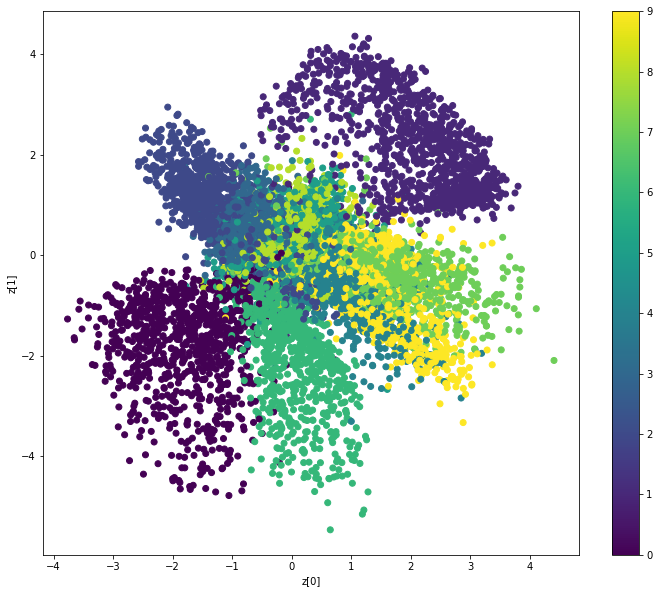

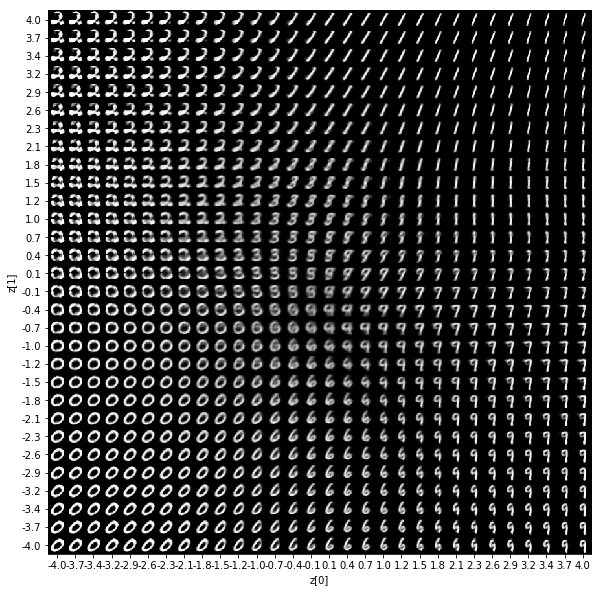

In [41]:
# Fitting the parameters

vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')

plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")
